In [1]:
# IMPORTING SOME LIBRARY
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import math
import time
import datetime
import operator

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from xgboost import XGBClassifier

#plt.style.use('seaborn')
#%matplotlib inline

import plotly.express as px
import plotly.graph_objects as go

!pip install geopandas
!pip install descartes



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df=pd.read_csv('/content/drive/My Drive/COVID_19_Data/covid_19_india_updated.csv')
#df['Total Confirm']=df['ConfirmedIndianNational']+df['ConfirmedForeignNational']
print('Shape of the data:',df.shape)
df.head()

Shape of the data: (1190, 9)


,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
0,1,30/01/20,6:00 PM,Kerala,1,0,0,0,1
1,2,31/01/20,6:00 PM,Kerala,1,0,0,0,1
2,3,01/02/20,6:00 PM,Kerala,2,0,0,0,2
3,4,02/02/20,6:00 PM,Kerala,3,0,0,0,3
4,5,03/02/20,6:00 PM,Kerala,3,0,0,0,3


In [4]:
# prepaing data state wise
state_cases = df.groupby('State/UnionTerritory')['Confirmed','Deaths','Cured'].max().reset_index()
state_cases['Active'] = state_cases['Confirmed'] - (state_cases['Deaths']- state_cases['Cured'])
state_cases["Death Rate (per 100)"] = np.round(100*state_cases["Deaths"]/state_cases["Confirmed"],2)
state_cases.fillna(0, inplace = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [5]:
state_cases.sort_values('Confirmed', ascending= False).style.background_gradient(cmap='YlOrBr',subset=["Confirmed"])\
                        .background_gradient(cmap='Reds',subset=["Deaths"])\
                        .background_gradient(cmap='Greens',subset=["Cured"])\
                        .background_gradient(cmap='Blues',subset=["Active"])\
                        .background_gradient(cmap='Purples',subset=["Death Rate (per 100)"])

,State/UnionTerritory,Confirmed,Deaths,Cured,Active,Death Rate (per 100)
18,Maharashtra,4669,232,572,5009,4.970000
7,Delhi,2081,47,431,2465,2.260000
9,Gujarat,2066,77,131,2120,3.730000
27,Rajasthan,1576,25,205,1756,1.590000
17,Madhya Pradesh,1540,76,127,1591,4.940000
28,Tamil Nadu,1520,17,457,1960,1.120000
32,Uttar Pradesh,1294,20,140,1414,1.550000
29,Telengana,919,23,190,1086,2.500000
1,Andhra Pradesh,757,22,96,831,2.910000
14,Karnataka,415,17,114,512,4.100000


In [6]:
fig = px.bar(state_cases.sort_values('Confirmed', ascending= False).sort_values('Confirmed', ascending=True), 
             x="Confirmed", y="State/UnionTerritory", 
             title='Total Confirmed Cases', 
             text='Confirmed', 
             orientation='h', 
             width=700, height=1000)
fig.update_traces(marker_color='#FFA500', opacity=0.8, textposition='inside')

fig.update_layout(template = 'plotly_white')
fig.show()

In [7]:
fig = px.bar(state_cases.sort_values('Deaths', ascending= False).sort_values('Deaths', ascending=True), 
             x="Deaths", y="State/UnionTerritory", 
             title='Total Deaths Cases', 
             text='Deaths', 
             orientation='h', 
             width=700, height=1000)
fig.update_traces(marker_color='#FF0000', opacity=0.8, textposition='inside')

fig.update_layout(template = 'plotly_white')
fig.show()

In [8]:
fig = px.bar(state_cases.sort_values('Cured', ascending= False).sort_values('Cured', ascending=True), 
             x="Cured", y="State/UnionTerritory", 
             title='Total Cured Cases', 
             text='Cured', 
             orientation='h', 
             width=700, height=1000)
fig.update_traces(marker_color='#20e000', opacity=0.8, textposition='inside')

fig.update_layout(template = 'plotly_white')
fig.show()

In [9]:
df_confirm = pd.DataFrame(index=list(df['Date']) ,columns=list(df['State/UnionTerritory'])).T

confirm = list(df['Confirmed'])
for i,j in zip([i for i in range(0, len(list(df_confirm.keys()))+1)], confirm):
  df_confirm.iloc[i][i] = j

df_confirm.fillna(0, inplace=True)

df_confirm = df_confirm.groupby(axis=1, level=0,sort=False).sum()
df_confirm = df_confirm.groupby(axis=0, level=0).sum()

print(df_confirm.shape)
df_confirm.head()

(35, 83)


,30/01/20,31/01/20,01/02/20,02/02/20,03/02/20,04/02/20,05/02/20,06/02/20,07/02/20,08/02/20,09/02/20,10/02/20,11/02/20,12/02/20,13/02/20,14/02/20,15/02/20,16/02/20,17/02/20,18/02/20,19/02/20,20/02/20,21/02/20,22/02/20,23/02/20,24/02/20,25/02/20,26/02/20,27/02/20,28/02/20,29/02/20,01/03/20,02/03/20,03/03/20,04/03/20,05/03/20,06/03/20,07/03/20,08/03/20,09/03/20,...,13/03/20,14/03/20,15/03/20,16/03/20,17/03/20,18/03/20,19/03/20,20/03/20,21/03/20,22/03/20,23/03/20,24/03/20,25/03/20,26/03/20,27/03/20,28/03/20,29/03/20,30/03/20,31/03/20,01/04/20,02/04/20,03/04/20,04/04/20,05/04/20,06/04/20,07/04/20,08/04/20,09/04/20,10/04/20,11/04/20,12/04/20,13/04/20,14/04/20,15/04/20,16/04/20,17/04/20,18/04/20,19/04/20,20/04/20,21/04/20
Andaman and Nicobar Islands,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,6,9,9,10,10,10,10,10,10,10,10,10,11,11,11,11,11,11,11,11,11,12,14,15,16
Andhra Pradesh,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,2,3,3,5,7,8,9,11,12,14,19,23,40,83,86,132,161,190,226,266,305,348,363,381,381,432,473,503,534,572,603,603,722,757
Arunachal Pradesh,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Assam,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5,16,24,26,26,26,27,28,29,29,29,31,31,33,33,35,35,35,35,35
Bihar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2,2,3,4,6,6,9,11,15,15,23,24,29,30,30,32,32,38,39,60,60,64,64,66,70,74,83,85,86,96,114


In [10]:
df_confirm['21/04/20'].sum()

18985

In [11]:
df_death = pd.DataFrame(index=list(df['Date']) ,columns=list(df['State/UnionTerritory'])).T

# Death details entry to the empty dataframe
death = list(df['Deaths'])

for i,j in zip([i for i in range(0, len(list(df_death.keys()))+1)], death):
  df_death.iloc[i][i] = j

# fill the NaN value as 0
df_death.fillna(0, inplace=True)

# df_death.head()
# Combine all the similar dataes:
df_death = df_death.groupby(axis=1, level=0,sort=False).sum()
df_death=df_death.groupby(axis=0, level=0,sort=False).sum()

df_death.head()

,30/01/20,31/01/20,01/02/20,02/02/20,03/02/20,04/02/20,05/02/20,06/02/20,07/02/20,08/02/20,09/02/20,10/02/20,11/02/20,12/02/20,13/02/20,14/02/20,15/02/20,16/02/20,17/02/20,18/02/20,19/02/20,20/02/20,21/02/20,22/02/20,23/02/20,24/02/20,25/02/20,26/02/20,27/02/20,28/02/20,29/02/20,01/03/20,02/03/20,03/03/20,04/03/20,05/03/20,06/03/20,07/03/20,08/03/20,09/03/20,...,13/03/20,14/03/20,15/03/20,16/03/20,17/03/20,18/03/20,19/03/20,20/03/20,21/03/20,22/03/20,23/03/20,24/03/20,25/03/20,26/03/20,27/03/20,28/03/20,29/03/20,30/03/20,31/03/20,01/04/20,02/04/20,03/04/20,04/04/20,05/04/20,06/04/20,07/04/20,08/04/20,09/04/20,10/04/20,11/04/20,12/04/20,13/04/20,14/04/20,15/04/20,16/04/20,17/04/20,18/04/20,19/04/20,20/04/20,21/04/20
Kerala,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3
Telengana,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,3,3,7,7,7,7,7,7,7,7,9,9,16,17,18,18,18,18,18,21,23
Delhi,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,4,4,6,7,7,7,9,9,13,14,19,24,28,30,32,38,42,43,45,47
Rajasthan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3,3,11,11,11,14,25
Uttar Pradesh,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,3,3,3,4,4,4,5,5,5,11,13,14,14,17,17,20


In [12]:
# create new data frame df_cured
df_cured = pd.DataFrame(index=list(df['Date']) ,columns=list(df['State/UnionTerritory'])).T

# cured details entry to the empty dataframe
cured = list(df['Cured'])
for i,j in zip([i for i in range(0, len(list(df_cured.keys()))+1)], cured):
  df_cured.iloc[i][i] = j


# fill the NaN value as 0
df_cured.fillna(0, inplace=True)

# Combine all the similar dataes:
df_cured = df_cured.groupby(axis=1, level=0,sort=False).sum()
df_cured = df_cured.groupby(axis=0, level=0).sum()

df_cured.head()

,30/01/20,31/01/20,01/02/20,02/02/20,03/02/20,04/02/20,05/02/20,06/02/20,07/02/20,08/02/20,09/02/20,10/02/20,11/02/20,12/02/20,13/02/20,14/02/20,15/02/20,16/02/20,17/02/20,18/02/20,19/02/20,20/02/20,21/02/20,22/02/20,23/02/20,24/02/20,25/02/20,26/02/20,27/02/20,28/02/20,29/02/20,01/03/20,02/03/20,03/03/20,04/03/20,05/03/20,06/03/20,07/03/20,08/03/20,09/03/20,...,13/03/20,14/03/20,15/03/20,16/03/20,17/03/20,18/03/20,19/03/20,20/03/20,21/03/20,22/03/20,23/03/20,24/03/20,25/03/20,26/03/20,27/03/20,28/03/20,29/03/20,30/03/20,31/03/20,01/04/20,02/04/20,03/04/20,04/04/20,05/04/20,06/04/20,07/04/20,08/04/20,09/04/20,10/04/20,11/04/20,12/04/20,13/04/20,14/04/20,15/04/20,16/04/20,17/04/20,18/04/20,19/04/20,20/04/20,21/04/20
Andaman and Nicobar Islands,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,10,10,10,10,10,11,11,11,11
Andhra Pradesh,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,5,6,7,11,11,11,14,16,20,36,42,42,92,96
Arunachal Pradesh,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Assam,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,9,12,17,19
Bihar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,26,26,29,29,37,37,37,42,42


In [0]:
dates = list(df['Date'].unique())
india_confirm_cases = []
india_death_cases = []
india_mortality_rate = []
india_recovery_rate = []
total_recovered = []
total_active = []
for i in dates:
  confirm_sum = df_confirm[i].sum()
  death_sum = df_death[i].sum()
  recovery_sum = df_cured[i].sum()
  india_confirm_cases.append(confirm_sum)
  india_death_cases.append(death_sum)
  india_mortality_rate.append(death_sum / confirm_sum)
  india_recovery_rate.append(recovery_sum / confirm_sum)
  total_recovered.append(recovery_sum)
  total_active.append(confirm_sum - death_sum - recovery_sum)

Text(0, 0.5, 'Cases')

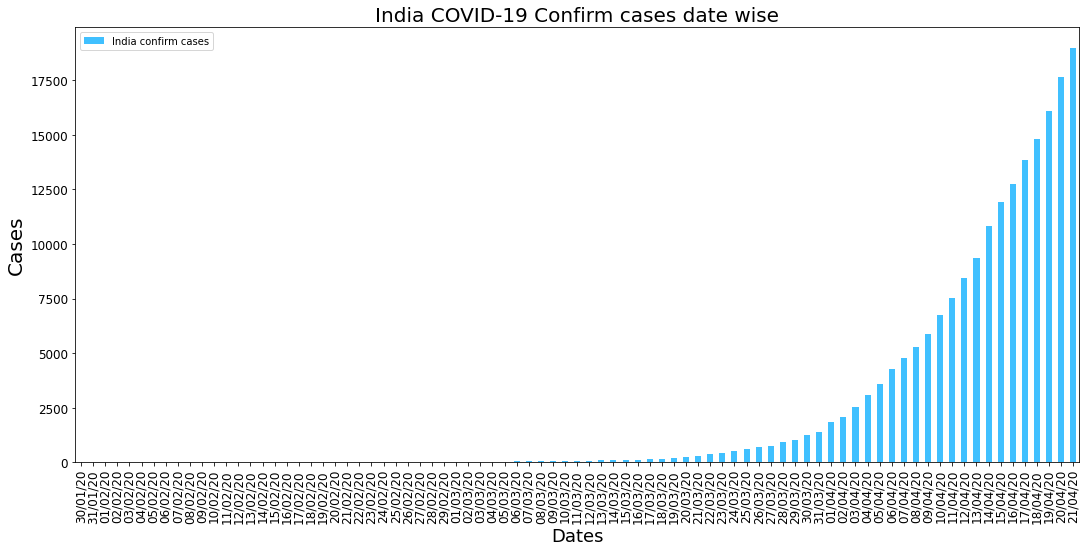

In [14]:
import operator

plt.rcParams['figure.figsize'] = (18,8)
bar_df = pd.DataFrame({'Dates':dates[0:], 'India confirm cases':india_confirm_cases[0:]})
bar_df.plot.bar(x='Dates', y='India confirm cases', rot=90, color='#40c0ff', title='India COVID-19 Confirm cases date wise',fontsize=12)
plt.title('India COVID-19 Confirm cases date wise',size=20)
plt.xlabel('Dates',size=18)
plt.ylabel('Cases',size=20)

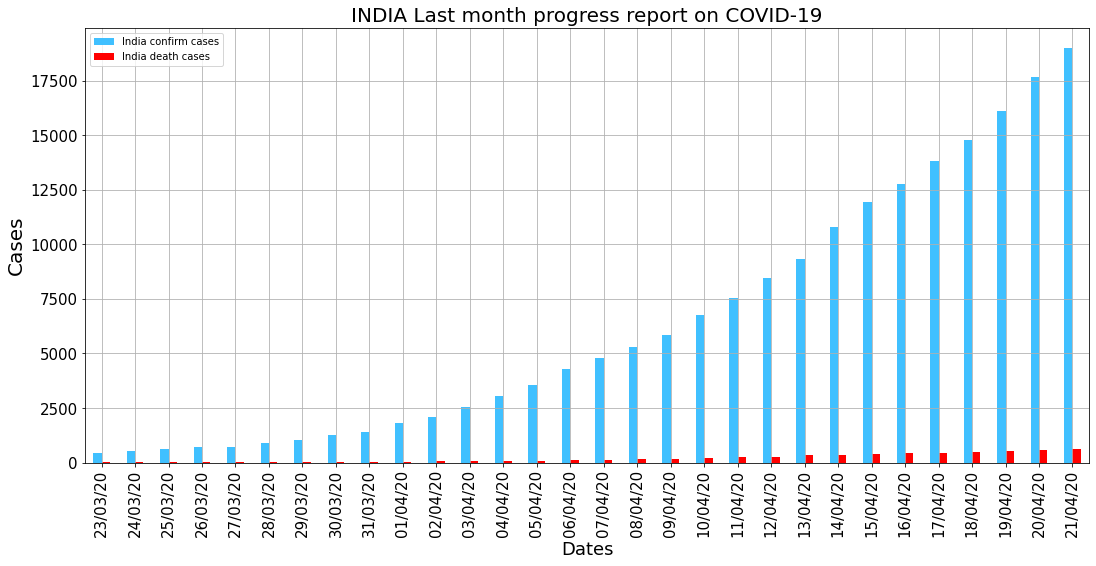

In [15]:
confirm_cases = india_confirm_cases[-30:]
death_cases = india_death_cases[-30:]
index = dates[-30:]
df2 = pd.DataFrame({'India confirm cases': confirm_cases,
'India death cases': death_cases}, index=index)
ax = df2.plot.bar(color=['#40c0ff', '#FF0000'], title='INDIA Last month progress report on COVID-19', fontsize=15)
plt.title('INDIA Last month progress report on COVID-19',size=20)
plt.xlabel('Dates',size=18)
plt.ylabel('Cases',size=20)
plt.grid('on')

In [16]:
import plotly.graph_objects as go
Total_Confirm=df_confirm['21/04/20'].sum()

Total_Death=df_death['21/04/20'].sum()

Total_Cured=df_cured['21/04/20'].sum()

labels = ["Active", "Death", "Recovery"]

values = [Total_Confirm,Total_Death,Total_Cured]
colors =  ['#4080ff', '#FF0000', '#20e000']

# Use hole to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3,marker_colors=colors)])
fig.update_layout(autosize=False,width=500,height=500)
fig.update(layout_title_text='INDIA COVID-19 +VE cases, Death & Recovery')

fig.show()

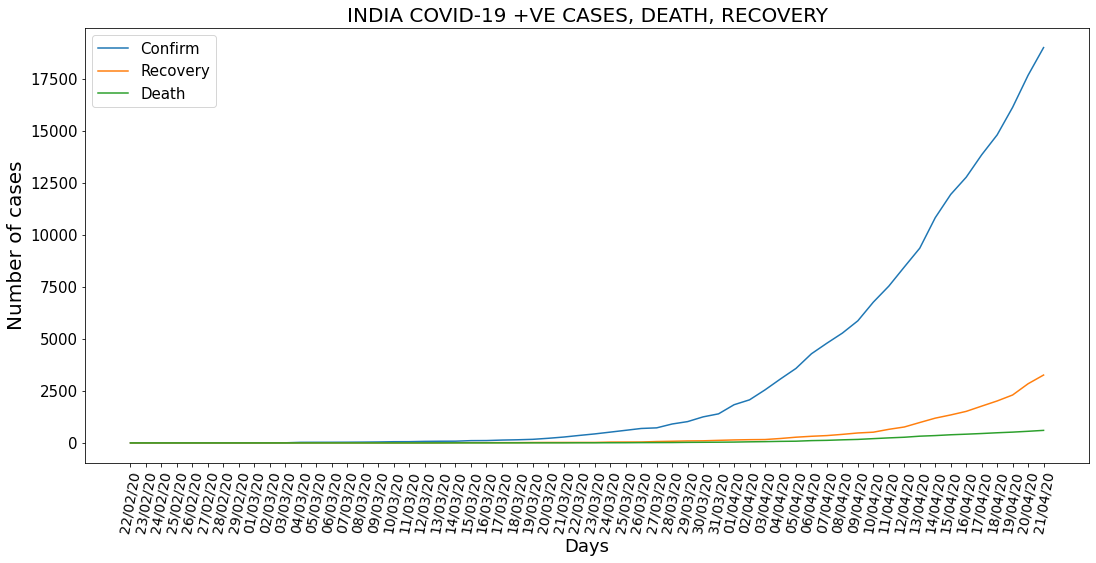

In [17]:
plt.figure(figsize=(18,8))
plt.plot(dates[-60:], india_confirm_cases[-60:])
plt.plot(dates[-60:], total_recovered[-60:])
plt.plot(dates[-60:], india_death_cases[-60:])
plt.title('INDIA COVID-19 +VE CASES, DEATH, RECOVERY', size=20)
plt.xlabel('Days', size=18)
plt.ylabel('Number of cases', size=20)
plt.legend(['Confirm', 'Recovery', 'Death'], prop={'size': 15})
plt.xticks(size=20, rotation=80, fontsize=14)
plt.yticks(size=15)
plt.show()

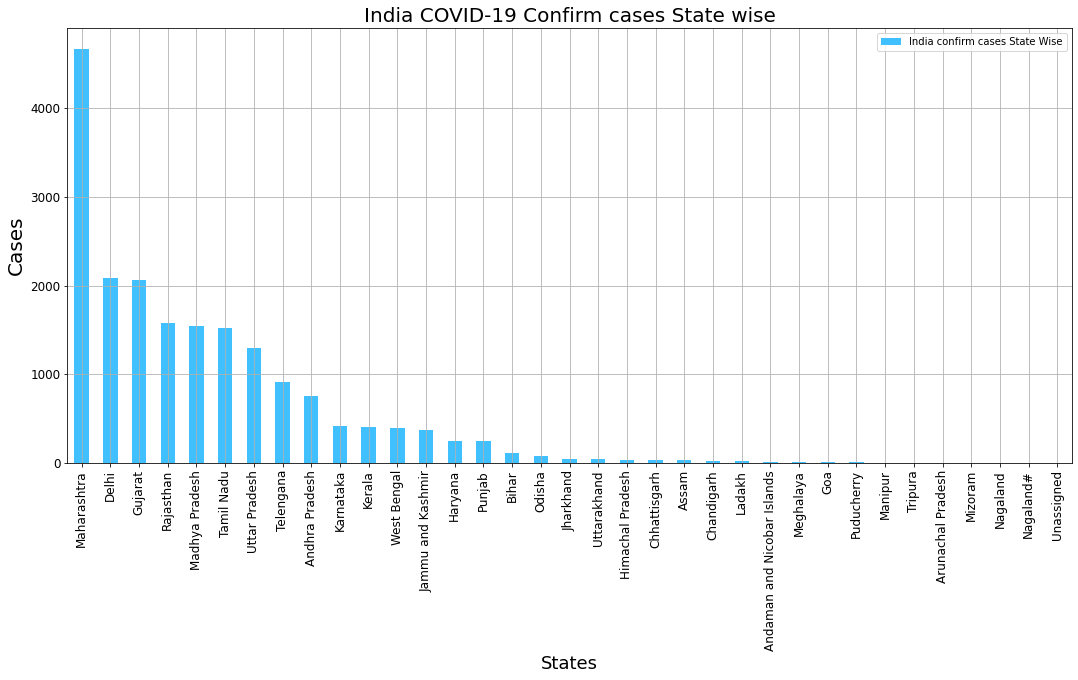

In [18]:
dc=dict(df_confirm["21/04/20"])
dc=sorted(dc.items(), key=lambda x: x[1],reverse=True)
x=[]
y=[]
for i,j in dc:
  x.append(i)
  y.append(j)

bar_df1 = pd.DataFrame({'States':x[0:], 'India confirm cases State Wise':y[0:]})
bar_df1.plot.bar(x='States', y='India confirm cases State Wise', rot=90, color='#40c0ff', title='India COVID-19 Confirm cases State wise',fontsize=12)
plt.title('India COVID-19 Confirm cases State wise',size=20)
plt.xlabel('States',size=18)
plt.ylabel('Cases',size=20)
plt.grid('on')

In [0]:
data_state=pd.DataFrame.from_dict(dc)
data_state.at[12,0]='Jammu & Kashmir'
data_state.at[7,0]='Telangana'
data_state.at[24,0]='Andaman & Nicobar Island'
data_state.at[30,0]='Arunanchal Pradesh'

In [0]:
import geopandas as gpd
fp = "Indian_States.shp"
map_df = gpd.read_file(fp)
merged = map_df.set_index('st_nm').join(data_state.set_index(0))
merged.fillna(0,inplace=True)
#merged

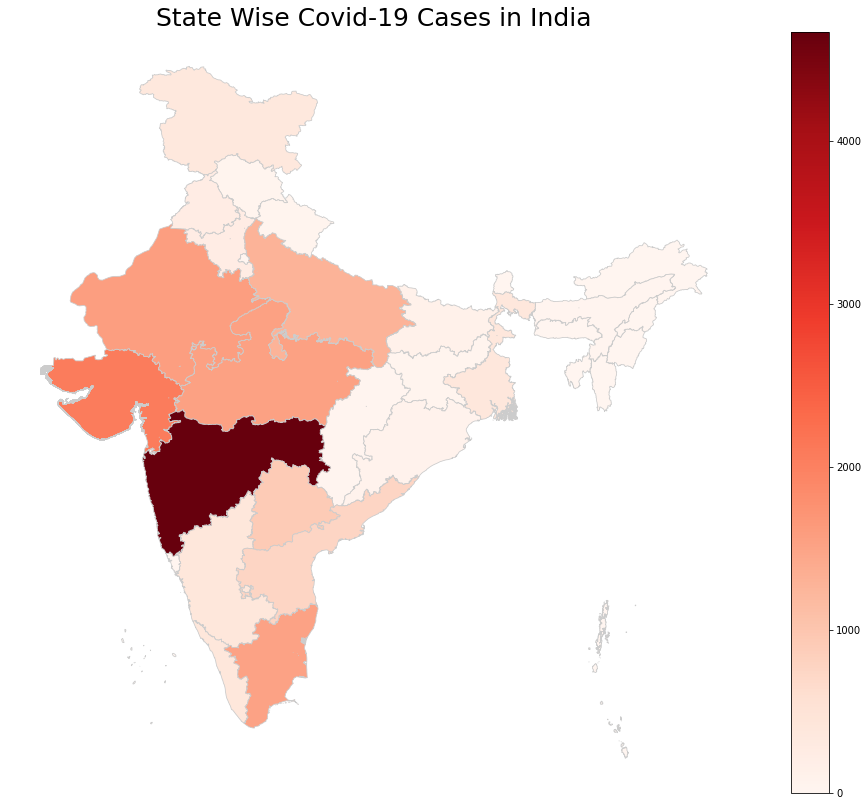

In [21]:
fig, ax = plt.subplots(1, figsize=(18, 14) )
ax.axis('off')
ax.set_title('State Wise Covid-19 Cases in India', fontdict={'fontsize': '25', 'fontweight' : '3'})
merged.plot(column=1, cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True )

In [0]:
Top_States=[]
Top_States_Names=[]
for x,y in dc[:5]:
  Top_States_Names.append(x)
  Top_States.append(list(df_confirm.loc[x]))

In [23]:
Top_States_Names

['Maharashtra', 'Delhi', 'Gujarat', 'Rajasthan', 'Madhya Pradesh']

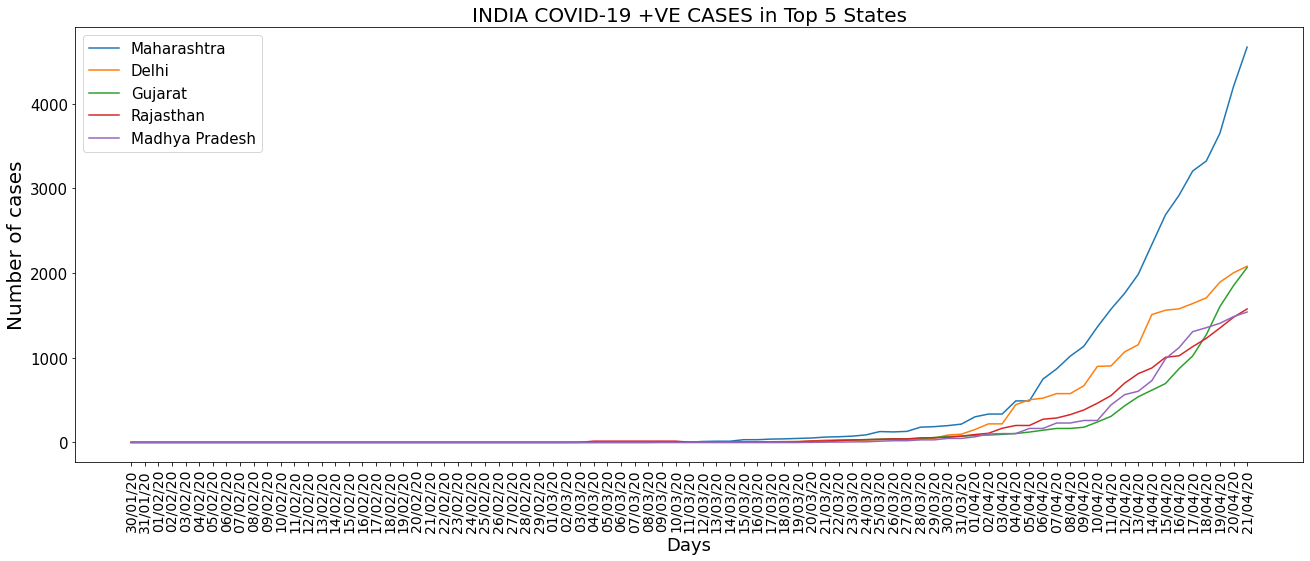

In [24]:
plt.figure(figsize=(22,8))
plt.plot(dates,Top_States[0])
plt.plot(dates, Top_States[1])
plt.plot(dates, Top_States[2])
plt.plot(dates, Top_States[3])
plt.plot(dates, Top_States[4])

plt.title('INDIA COVID-19 +VE CASES in Top 5 States', size=20)
plt.xlabel('Days', size=18)
plt.ylabel('Number of cases', size=20)
plt.legend(Top_States_Names, prop={'size': 15})
plt.xticks(size=20, rotation=90, fontsize=14)
plt.yticks(size=15)
plt.show()

In [25]:
days_in_future = 10
future_forecast = np.array([i for i in range(len(dates) + days_in_future)]).reshape(-1, 1)
print(len(future_forecast), ': Length of future_forecast')
adjusted_dates = future_forecast[:-10]

93 : Length of future_forecast


In [0]:
start = '30/01/2020'
start_date = datetime.datetime.strptime(start, '%d/%m/%Y')
future_forecast_dates = []
for i in range(len(future_forecast)):
  future_forecast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%d/%m/%Y'))

In [0]:
day_since_30_1 = np.array([i for i in range(len(dates))]).reshape(-1, 1)

In [0]:
X=india_confirm_cases
Y=day_since_30_1

In [0]:
x_train_confirm, x_test_confirm, y_train_confirm, y_test_confirm = train_test_split(Y,X,test_size=0.02, shuffle=False)

In [30]:
svm_model = SVR(shrinking=True, kernel='poly', gamma=0.01, epsilon=1, degree=6, C=0.020)
svm_model.fit(x_train_confirm, y_train_confirm)
svm_test_pred = svm_model.predict(x_test_confirm)
print('MSE:', mean_squared_error(svm_test_pred, y_test_confirm))
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirm))
print('R^2:', r2_score(svm_test_pred, y_test_confirm))

MSE: 3906824.8618535306
MAE: 1975.625492080755
R^2: -9.729045722547179


In [0]:
future_svm_pred = svm_model.predict(future_forecast)

In [0]:
last_dates = future_forecast_dates[-10:]

22/04/2020 : 18231
23/04/2020 : 19593
24/04/2020 : 21039
25/04/2020 : 22573
26/04/2020 : 24198
27/04/2020 : 25920
28/04/2020 : 27742
29/04/2020 : 29669
30/04/2020 : 31707
01/05/2020 : 33860


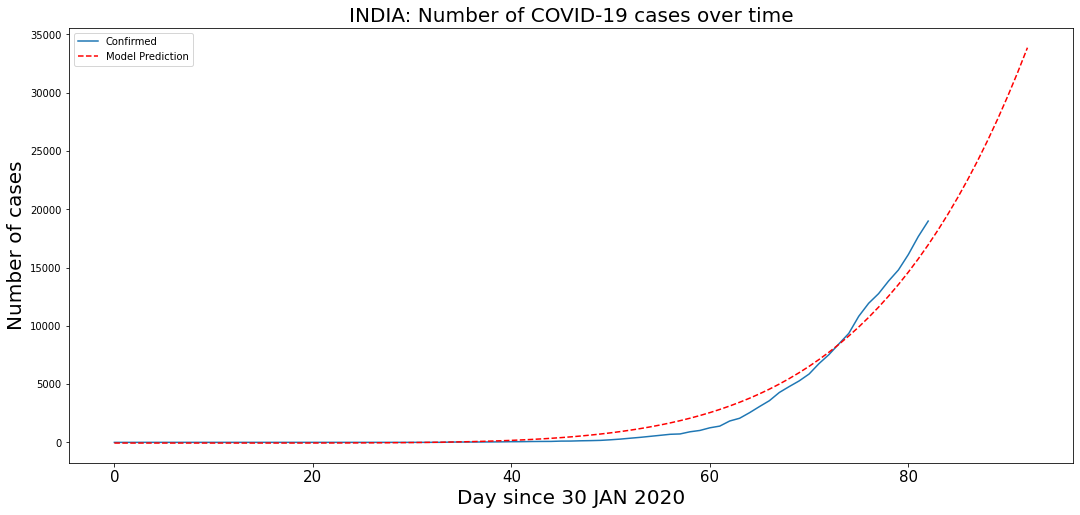

In [33]:
last_pred = list(future_svm_pred)[-10:]
last_pred_list = [int(round(i)) for i in last_pred]
for i, j in zip(last_dates, last_pred_list):
  print(i, ':', j)
plt.figure(figsize=(18,8))
plt.plot(adjusted_dates,X)
plt.plot(future_forecast, future_svm_pred, linestyle='dashed', color='red')
plt.title('INDIA: Number of COVID-19 cases over time', size=20)
plt.xlabel('Day since 30 JAN 2020', size=20)
plt.ylabel('Number of cases', size=20)
plt.legend(['Confirmed', 'Model Prediction'])
plt.xticks(size=15)
plt.show()

In [0]:
dates = list(df['Date'].unique())

In [35]:
len(dates)

83

In [0]:
temp_dict = dict(zip(last_dates, last_pred_list))

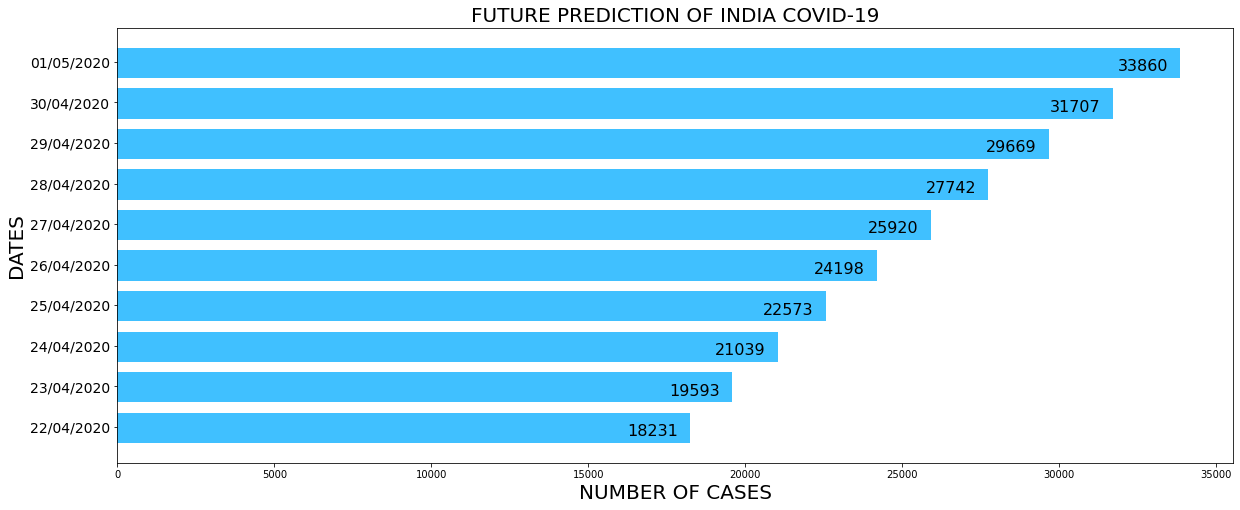

In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt
x = list(temp_dict.keys())
y = list(temp_dict.values())
fig, ax = plt.subplots(figsize=(20,8))
width = 0.75 # the width of the bars
ind = np.arange(len(y)) # the x locations for the groups
ax.barh(ind, y, width, color="#40c0ff")
ax.set_yticks(ind+width/30)
ax.set_yticklabels(x, minor=False, fontsize=14)
plt.title('FUTURE PREDICTION OF INDIA COVID-19', fontsize=20)
plt.xlabel('NUMBER OF CASES', fontsize=20)
plt.ylabel('DATES', fontsize=20)
#plt.show()
#plt.savefig(os.path.join('test.png'), dpi=300, format='png', bbox_inches='tight', color='#40c0ff')
for i, v in enumerate(y):
  ax.text(v + -2000, i + -0.2, str(v), color='black', fontsize=16)

In [0]:
future_forecast_dates
future_prediction = [int(round(future_svm_pred[i])) for i in range(len(future_svm_pred))]

In [0]:
weeks = future_forecast_dates[0::7][-5:]
weeks_report = future_prediction[0::7][-5:]

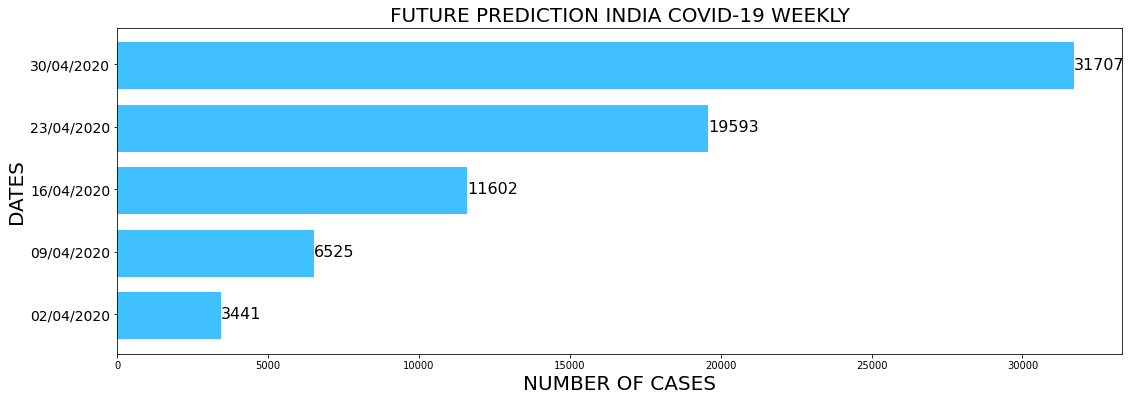

In [40]:
import os
import numpy as np
import matplotlib.pyplot as plt
x = weeks
y = weeks_report
fig, ax = plt.subplots(figsize=(18,6))
width = 0.75 # the width of the bars
ind = np.arange(len(y)) # the x locations for the groups
ax.barh(ind, y, width, color="#40c0ff")
ax.set_yticks(ind+width/30)
ax.set_yticklabels(x, minor=False, fontsize=14)
plt.title('FUTURE PREDICTION INDIA COVID-19 WEEKLY', fontsize=20)
plt.xlabel('NUMBER OF CASES', fontsize=20)
plt.ylabel('DATES', fontsize=20)
#plt.show()
#plt.savefig(os.path.join('test.png'), dpi=300, format='png', bbox_inches='tight', color='#40c0ff')
for i, v in enumerate(y):
  ax.text(v + 5, i + -0.05, str(v), color='k', fontsize=16)